In [1]:
from __future__ import print_function
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg19
from keras import backend as k 
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [44]:
content_image_path="tiger.png"
style_reference_image_path='style.png'

result_prefix='gen'

iteration=10

content_weight=0.05

style_weight=0.4

In [45]:
width,height=load_img(content_image_path).size
gen_height=400
gen_width=(int(width/height)*gen_height)

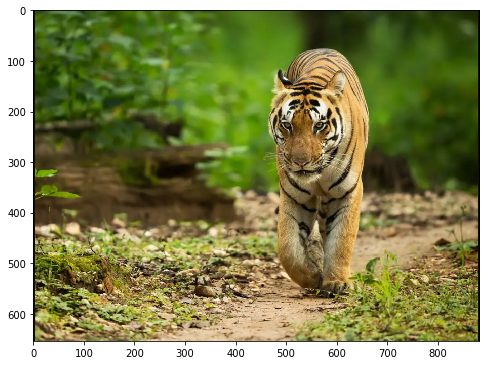

In [46]:
from skimage.transform import resize
fig=plt.figure(figsize=(8,8))
content_img=(cv2.imread('tiger.png'))
plt.imshow(cv2.cvtColor(content_img,cv2.COLOR_BGR2RGB))

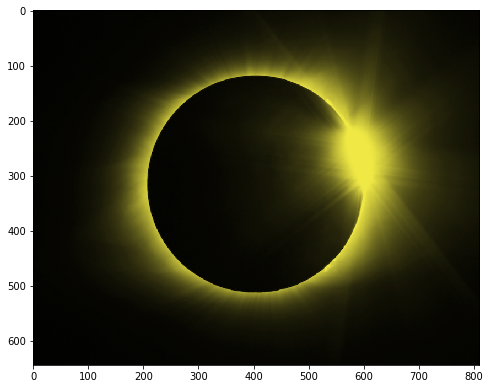

In [47]:
flt=plt.figure(figsize=(8,8))
style_img=cv2.imread('style.png')
plt.imshow(cv2.cvtColor(style_img,cv2.COLOR_BGR2RGB))

In [48]:
def preprocess_image(image_path):
    img=load_img(image_path,target_size=(gen_height,gen_width))
    img=img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=vgg19.preprocess_input(img)
    return img

In [49]:
def deprocess_image(x):
    x=x.reshape((gen_height,gen_width,3))
    x[:,:,0]+=np.mean(x[:,:,0])
    x[:,:,1]+=np.mean(x[:,:,1])
    x[:,:,2]+=np.mean(x[:,:,2])
    x=x[:,:,::-1]
    x=np.clip(x,0,255).astype('uint8')
    return x

In [50]:
content_image=k.variable(preprocess_image(content_image_path))
style_reference_image=k.variable(preprocess_image(style_reference_image_path))
generated_image=k.placeholder((1,gen_height,gen_width,3))
input_tensor = k.concatenate([content_image,style_reference_image,generated_image],axis=0)


In [51]:
model=vgg19.VGG19(input_tensor=input_tensor,weights='imagenet',include_top=False)


In [52]:
print("Summary of the model",model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [53]:
outputs_dict=dict([(layer.name,layer.output) for layer in model.layers])
print(outputs_dict)

{'input_3': <tf.Tensor 'concat_2:0' shape=(3, 400, 400, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1_2/Relu:0' shape=(3, 400, 400, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2_2/Relu:0' shape=(3, 400, 400, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool_2/MaxPool:0' shape=(3, 200, 200, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1_2/Relu:0' shape=(3, 200, 200, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2_2/Relu:0' shape=(3, 200, 200, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool_2/MaxPool:0' shape=(3, 100, 100, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1_2/Relu:0' shape=(3, 100, 100, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2_2/Relu:0' shape=(3, 100, 100, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3_2/Relu:0' shape=(3, 100, 100, 256) dtype=float32>, 'block3_conv4': <tf.Tensor 'block3_conv4_2/Relu:0' shape=(3, 100, 100, 256) dtype=float32>, 'block

In [54]:
layer_features=outputs_dict['block5_conv2']
content_image_features=layer_features[0,:,:,:]
print("shape of content image feature is ",content_image_features.shape)

generated_features=layer_features[2,:,:,:]
print("shape of the generate feature is ",generated_features.shape)

shape of content image feature is  (25, 25, 512)
shape of the generate feature is  (25, 25, 512)


In [55]:
def gram_matrix(x):
    features=k.batch_flatten(k.permute_dimensions(x,(2,0,1)))
    gram=k.dot(features,k.transpose(features))
    return gram

In [56]:
def style_loss(style,generation):
    assert k.ndim(style)==3
    assert k.ndim(generation)==3
    S= gram_matrix(style)
    C= gram_matrix(generation)
    
    channels=3
    size=gen_width*gen_height
    return k.sum(k.square(S-C))/(4.*(channels**2)*(size ** 2))

In [57]:
def content_loss(content,generation):
    return k.sum(k.square(generation - content))

In [58]:
loss=k.variable(0.)
loss += content_weight * content_loss(content_image_features,generated_features)

In [59]:
feature_layers= ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
loss
for layer_name in feature_layers:
    layers_features = outputs_dict[layer_name]
    
    style_reference_features= layers_features[1,:,:,:]
    generated_features= layers_features[2,:,:,:]
    
    sl=style_loss(style_reference_features,generated_features)
    loss += (style_weight/ len(feature_layers))*sl


In [60]:
grads=k.gradients(loss, generated_image)
outputs=[loss]
if isinstance(grads, (list,tuple)):
    outputs +=grads
else:
    outputs.append(grads)
f_outputs=k.function([generated_image],outputs)

In [61]:
 def eval_loss_and_grads(x):
    x=x.reshape((1,gen_height,gen_width,3))
    outs=f_outputs([x])
    
    loss_value=outs[0]
    if len(outs[1:])==1:
        grad_values=outs[1].flatten().astype('float64')
    else:
        grad_values=np.array(outs[1:]).flatten().astype('float64')
    return loss_value,grad_values

In [62]:
class Evaluator(object):
    
    def __init__(self):
        self.loss_value= None
        self.grad_values= None
    
    def loss(self,x):
        loss_value, grad_values= eval_loss_and_grads(x)
        self.loss_value=loss_value
        self.grad_values=grad_values
        return self.loss_value
    
    def grads(self,x):
        assert self.loss_value is not None

        grad_values= np.copy(self.grad_values)
        self.loss_value=None
        self.grad_values= None
        
        return grad_values

In [63]:
evaluator=Evaluator()

In [65]:
x=preprocess_image(content_image_path)
iterations=10
for i in range(iterations):
    print("Start of iteration ",i)
    start_time=time.time()
    x, min_val, info =fmin_l_bfgs_b(evaluator.loss, x.flatten(),fprime=evaluator.grads, maxfun=20)
    
    print("Current loss value", min_val)
    
    img=deprocess_image(x.copy())
    fname= result_prefix+"_at_iteraation_%d.png" % i
    cv2.imwrite(fname, img)
    end_time=time.time()
    
    print("Image saved as ", fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration  0
Current loss value 1939802500.0
Image saved as  gen_at_iteraation_0.png
Iteration 0 completed in 11s
Start of iteration  1
Current loss value 1265627800.0
Image saved as  gen_at_iteraation_1.png
Iteration 1 completed in 11s
Start of iteration  2
Current loss value 1021180100.0
Image saved as  gen_at_iteraation_2.png
Iteration 2 completed in 11s
Start of iteration  3
Current loss value 886191400.0
Image saved as  gen_at_iteraation_3.png
Iteration 3 completed in 11s
Start of iteration  4
Current loss value 793551360.0
Image saved as  gen_at_iteraation_4.png
Iteration 4 completed in 11s
Start of iteration  5
Current loss value 728369500.0
Image saved as  gen_at_iteraation_5.png
Iteration 5 completed in 11s
Start of iteration  6
Current loss value 679142400.0
Image saved as  gen_at_iteraation_6.png
Iteration 6 completed in 11s
Start of iteration  7
Current loss value 640482900.0
Image saved as  gen_at_iteraation_7.png
Iteration 7 completed in 11s
Start of iteration  8

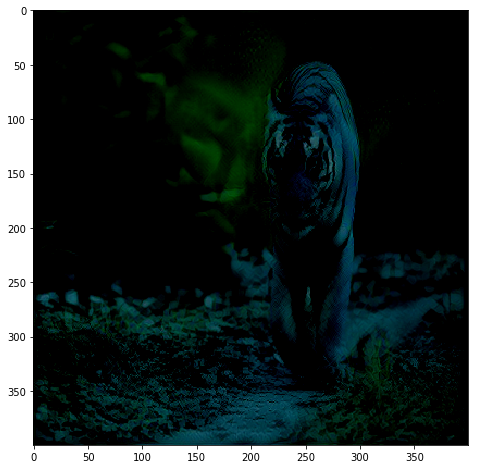

In [67]:
# Generated imaage at first iteration
fig=plt.figure(figsize=(8, 8))
gen_image_final = cv2.imread('gen_at_iteraation_1.png')    
plt.imshow(cv2.cvtColor(gen_image_final, cv2.COLOR_BGR2RGB))

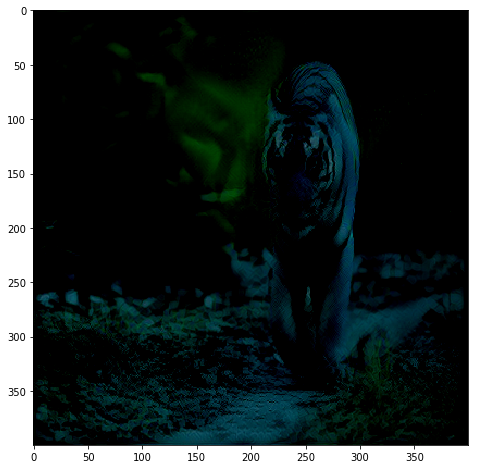

In [68]:
# Generated imaage at first iteration
fig=plt.figure(figsize=(8, 8))
gen_image_final = cv2.imread('gen_at_iteraation_2.png')    
plt.imshow(cv2.cvtColor(gen_image_final, cv2.COLOR_BGR2RGB))